<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/ExtracellularSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [3]:
try:
    from google.colab import files
except:
    print("The program is running with local host")
    
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [4]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

Load pre-defined functions from GitHub


# Working on the mesh

In [0]:
file_name='2E_ExtraCellular_group_10um_vol'
zip_exists = os.path.isfile(file_name+'.msh')
if zip_exists==False:
    file_dir='https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/'+file_name+'.msh.zip'
    !wget -q $file_dir
    !unzip -q $file_name''.msh.zip
!dolfin-convert $file_name''.msh $file_name''.xml

mymesh = Mesh(file_name+'.xml');
gdim = mymesh.geometry().dim()
tdim = mymesh.topology().dim()

print('Topological dimension: ',tdim)
print('Geometrical dimension: ',gdim)
print('Mesh size: #vertices: '+str(mymesh.num_vertices()) +', #elements: '+str(mymesh.num_cells()) );

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 504294 vertices
Found all vertices
Expecting 1505982 cells
Found all cells
Conversion done
Topological dimension:  3
Geometrical dimension:  3
Mesh size: #vertices: 504294, #elements: 1505982


# Solve the Bloch-Torrey equation

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
t:   0.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 0.00%
t: 2000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 3.59%
t: 4000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 7.18%
t: 6000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 10.77%
t: 8000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 14.36%
t: 10000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 17.95%
t: 12000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 21.54%
t: 14000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 25.13%
t: 16000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 28.73%
t: 18000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 32.32%
t: 20000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 35.91%
t: 22000.00  T: 53700.00 dt: 2000.0 gnorm: 2.999573e-05 Completed 39.50%
t: 24000.00  T

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


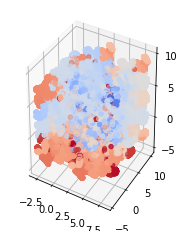

In [0]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.stype='PGSE'                                # sequence type
mri_para.bvalue = 4000;                              # bvalue
mri_para.delta, mri_para.Delta = 10600, 43100        # time sequence
mri_para.set_gradient_dir(mymesh, 0, 1, 0)           # gradient direction

mri_para.T = mri_para.Delta+mri_para.delta
mri_para.fs_sym = sp.Piecewise(
                (  1., mri_para.s < mri_para.delta ),
                (  0., mri_para.s < mri_para.Delta ),
                ( -1., mri_para.s < mri_para.T ),
                (  0., True )  
            ) 

mri_para.Apply()
mri_simu.k = 2000;                                   # time-step size
mri_simu.nskip = 1;                                  # frequency to print ouputs
mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = None
mydomain.PeriodicDir = [0, 0, 0];             # Direction of the periodicity
mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
mydomain.kappa = 1e-5                         # Permeability
################################################################################
mydomain.Apply()   # Call Apply before setting the diffusion tensor
################################################################################
# Impose the diffusion coefficient
mydomain.D0 = 3e-3
mydomain.D = mydomain.D0;
#################################################################################

mri_simu.solve(mydomain, mri_para, PETScLUSolver("mumps"))

Post_processing(mydomain, mri_para, mri_simu, plt, 'Extracellular Simulation')
# Post_processing(mydomain, mri_simu,'Extracellular Simulation')